<a href="https://colab.research.google.com/github/PedroNVSRamos/justplay_casestudy/blob/main/justplay_casestudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Hello!

# I used a mixture of SQL (via duckDB), Python for data wrangling and statistical
# analysis, and R to produce more informative visuals (mostly using ggplot since
# I'm more proeficient on that than matplotlib).

# I wrote some assumptions in comments throughout the notebook, as well as several
# methodology breakdowns and code annotations. I also wrote more formal explanation
# of the analysis that provides some context on how I approached each question.

# The report for the PM can be found in the following doc:
# https://docs.google.com/document/d/1nyYSOvSaQjY9UPHcXxkBKl70Fi4FXAjXKOucX01ew00/edit?usp=sharing

# My use of generative AI tools was mostly for debugging, with main chuncks of
# code being produced on my own, as well as the general scope and insights.

# Hope you enjoy it! :)

In [2]:

import pandas as pd
import gdown
import duckdb as ddb
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu

In [3]:
 %load_ext rpy2.ipython

In [4]:
%%R
#install.packages("tidyverse", dependencies=TRUE)
library(tidyverse)
library(scales)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor



In [5]:
file_id_revenue = "1Pz99aPmmY_45K0NM_8a9UewYOecZBmJs"
file_id_users = "1jDDdpZaPpZxhdXDLUnZ9vnX1GjVFBMkp"

direct_url_template = "https://drive.google.com/uc?export=view&id="

direct_url_revenue = direct_url_template + file_id_revenue
direct_url_users = direct_url_template + file_id_users

#print(direct_url_revenue)
#print(direct_url_users)

In [6]:
# download the files into sample_data folder
gdown.download(direct_url_revenue, "sample_data/revenue.csv", quiet = False)
gdown.download(direct_url_users, "sample_data/users.csv", quiet = False, )

Downloading...
From (original): https://drive.google.com/uc?export=view&id=1Pz99aPmmY_45K0NM_8a9UewYOecZBmJs
From (redirected): https://drive.google.com/uc?export=view&id=1Pz99aPmmY_45K0NM_8a9UewYOecZBmJs&confirm=t&uuid=00e49329-bc2f-4ca0-a63f-1f80f045b5cc
To: /content/sample_data/revenue.csv
100%|██████████| 1.60G/1.60G [00:20<00:00, 78.1MB/s]
Downloading...
From: https://drive.google.com/uc?export=view&id=1jDDdpZaPpZxhdXDLUnZ9vnX1GjVFBMkp
To: /content/sample_data/users.csv
100%|██████████| 102M/102M [00:00<00:00, 211MB/s] 


'sample_data/users.csv'

In [7]:
# read the files into dataframes
#df_revenue = pd.read_csv("sample_data/revenue.csv")
#df_users = pd.read_csv("sample_data/users.csv")

In [8]:
#print("Columns in revenue dataframe:\n")
#print(list(df_revenue.columns))
#print("\n\n\n")
#print("Columns in users dataframe:\n")
#print(list(df_users.columns))

In [9]:
# set up duckDB connection
ddb_con = ddb.connect()

In [10]:
# queries for importing .csv files into duckDB tables
sql_revenue = """
create table justplay_revenue as
  (
  select *
  from read_csv_auto('sample_data/revenue.csv')
  );
"""

sql_users = """
create table justplay_users as
  (
  select *
  from read_csv_auto('sample_data/users.csv')
  );
"""

ddb_con.execute(sql_revenue)
ddb_con.execute(sql_users)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [11]:
# query to join tables
sql_join = """
create or replace table justplay_joined_data as
  (
  select *,
    case when variation = 'default' then 'A: default (control)'
         when variation = 'androidndorder' then 'B: Nd_Order'
         when variation = 'androidnd1order' then 'C: Nd1_Order'
         when variation = 'androidnd7order' then 'D: Nd7_Order'
         when variation = 'androidnd30order' then 'E: Nd30_Order'
    else null end as group_id,
  from justplay_users as users
  left join justplay_revenue using(user_id)
  order by user_id, created_at
  )
"""

ddb_con.execute(sql_join)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [12]:
# Exploratory analysis

In [13]:
sql = """
select group_id, activated, count(distinct user_id) as unique_users
from justplay_joined_data
group by 1, 2
order by 1
"""

df_users_per_group_activated = ddb_con.execute(sql).fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

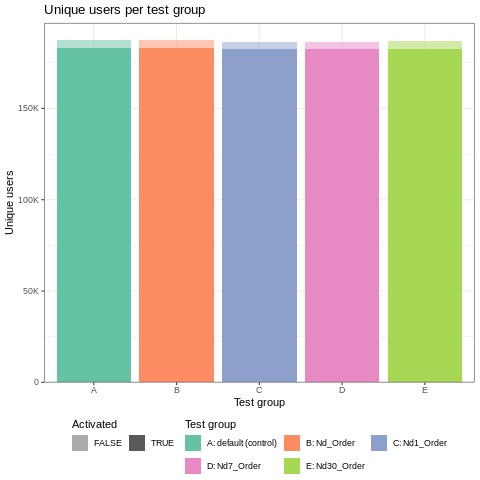

In [14]:
%%R -i df_users_per_group_activated

df_users_per_group_activated |>
  mutate(activated = as.factor(as.logical(activated))) |>
  ggplot(aes(x = group_id, y = unique_users,, group = interaction(group_id, activated))) +
    geom_bar(aes(fill = group_id, alpha = activated),
             stat = "identity") +
    scale_x_discrete(name = "Test group",
                     labels = function(x) sub(":.*", "", x)) +
    scale_y_continuous(name = "Unique users",
                       labels = label_number(scale_cut = cut_short_scale()),
                       expand = expansion(mult = c(0,0.05))) +
    expand_limits(y = 0) +
    scale_fill_brewer(name = "Test group", palette = "Set2") +
    scale_alpha_manual(name = "Activated", values = c("TRUE" = 1, "FALSE" = 0.5)) +
    ggtitle(label = "Unique users per test group") +
    theme_bw() +
    guides(fill = guide_legend(nrow = 2, byrow = TRUE)) +
    theme(legend.position = "bottom",
          legend.title.position = "top",
          legend.margin = margin())

In [15]:
sql = """
select group_id,
  assignment_dt,
    count(distinct user_id) as unique_users
from
  (
  select user_id,
    group_id,
    min(assignment_dt) as assignment_dt
  from justplay_joined_data
  group by 1, 2
  )
group by 1, 2
order by 1, 2
"""

df_users_assignment = ddb_con.execute(sql).fetchdf()

In [16]:
sql = """
select user_id,
  group_id,
  min(assignment_dt) as assignment_dt,
  min(install_dt) as install_dt
from justplay_joined_data
group by 1, 2
"""

df_users_install_vs_assignment = ddb_con.execute(sql).fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

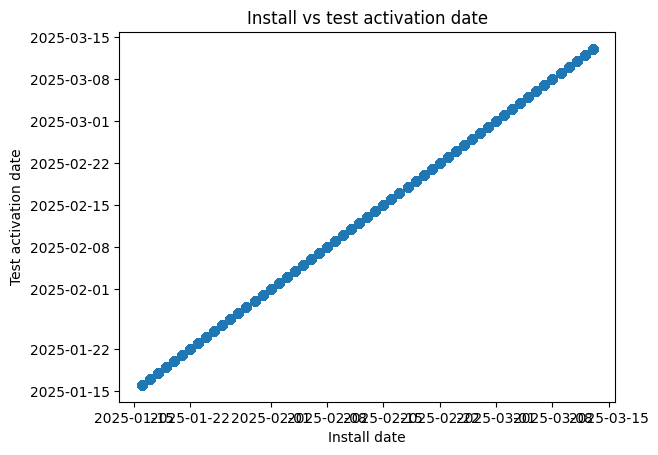

In [17]:
plt.scatter(x = df_users_install_vs_assignment['install_dt'], y = df_users_install_vs_assignment['assignment_dt'])
plt.xlabel("Install date")
plt.xticks(rotation = 0, ha = "center")
plt.ylabel("Test activation date")
plt.title("Install vs test activation date")
#plt.gca().yaxis.set_major_formatter(lambda x, pos: f"{x*100:.1f}%")
plt.show()

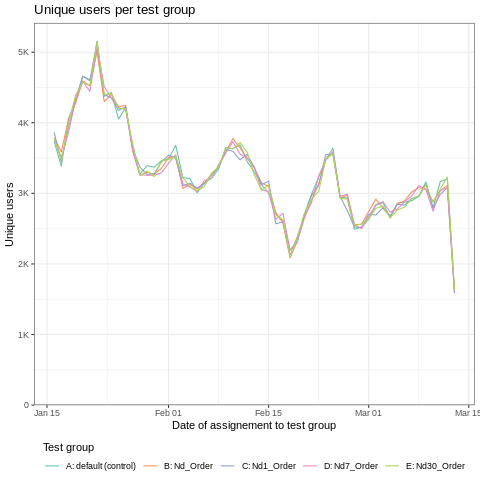

In [18]:
%%R -i df_users_assignment

df_users_assignment |>
  ggplot(aes(x = as.Date(assignment_dt), y = unique_users, color = group_id)) +
    geom_line(stat = "identity") +
    scale_x_date(name = "Date of assignement to test group") +
    scale_y_continuous(name = "Unique users",
                       labels = label_number(scale_cut = cut_short_scale()),
                       expand = expansion(mult = c(0,0.05))) +
    expand_limits(y = 0) +
    scale_color_brewer(name = "Test group", palette = "Set2") +
    ggtitle(label = "Unique users per test group") +
    #guides(color = guide_legend(nrow = 5, byrow = TRUE)) +
    theme_bw() +
    theme(legend.position = "bottom",
          legend.title.position = "top",
          legend.margin = margin())

In [19]:
sql = """
select group_id,
  channel,
  count(distinct user_id) as unique_users
from justplay_joined_data
group by 1, 2
order by 1, 3 desc
"""

df_users_per_channel = ddb_con.execute(sql).fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [20]:

df_users_per_channel_tmp = (
    df_users_per_channel.sort_values(['group_id', 'unique_users'], ascending = [True, False])
      .assign(total_users = lambda d: d.groupby('group_id')['unique_users'].transform('sum'))
      .assign(users_share = lambda d: d['unique_users'] / d['total_users'])
      .assign(cumulative_share = lambda d: d.groupby('group_id')['users_share'].cumsum())
      .assign(channel_grouped = lambda d: np.where(
          d['users_share'] < 0.01,
          'others (total < 1%)',
          d['channel']
          )
      )
)

df_users_per_channel_tmp[df_users_per_channel_tmp['group_id'].str.startswith('A:')]


df_users_per_channel_clean = (
    df_users_per_channel_tmp
    .groupby(['group_id', 'channel_grouped'], as_index = False)
    .agg(unique_users = ('unique_users', 'sum'))
    .sort_values(['group_id', 'unique_users'], ascending = [True, False])
    .assign(
        total_users = lambda d: d.groupby('group_id')['unique_users'].transform('sum'),
        users_share = lambda d: d['unique_users'] / d['total_users'],
        cumulative_share = lambda d: d.groupby('group_id')['users_share'].cumsum()
    )
)

df_users_per_channel_clean[df_users_per_channel_clean['group_id'].str.startswith('A:')]


,group_id,channel_grouped,unique_users,total_users,users_share,cumulative_share
2,A: default (control),google ads aci,69076,187405,0.368592,0.368592
5,A: default (control),missing,43604,187405,0.232673,0.601265
7,A: default (control),organic,25661,187405,0.136928,0.738193
0,A: default (control),applovin,18692,187405,0.099741,0.837934
4,A: default (control),mintegral,15647,187405,0.083493,0.921427
8,A: default (control),others (total < 1%),3958,187405,0.021120,0.942547
6,A: default (control),moloco,3072,187405,0.016392,0.958939
1,A: default (control),facebook,3045,187405,0.016248,0.975187
9,A: default (control),untrusted devices,2414,187405,0.012881,0.988069
3,A: default (control),liftoff,2236,187405,0.011931,1.000000


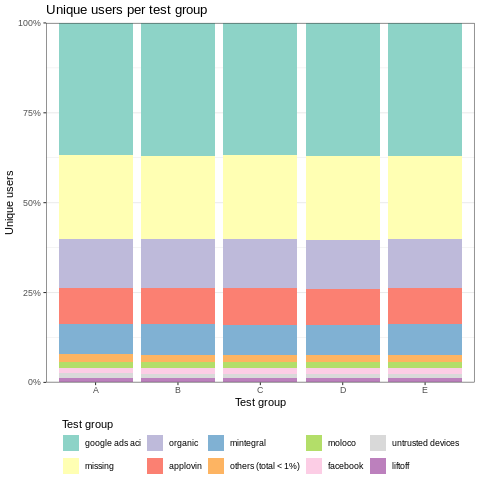

In [21]:
%%R -i df_users_per_channel_clean

df_users_per_channel_clean |>
  ggplot(aes(x = group_id, fill = fct_reorder(channel_grouped, -users_share))) +
    geom_bar(aes(y = users_share),
             stat = "identity", position = "stack") +
    scale_x_discrete(name = "Test group",
                     labels = function(x) sub(":.*", "", x)) +
    scale_y_continuous(name = "Unique users",
                       labels = percent,
                       expand = expansion(mult = c(0,0))) +
    expand_limits(y = 0) +
    scale_fill_brewer(name = "Test group", palette = "Set3") +
    ggtitle(label = "Unique users per test group") +
    theme_bw() +
    theme(legend.position = "bottom",
          legend.title.position = "top",
          legend.margin = margin())

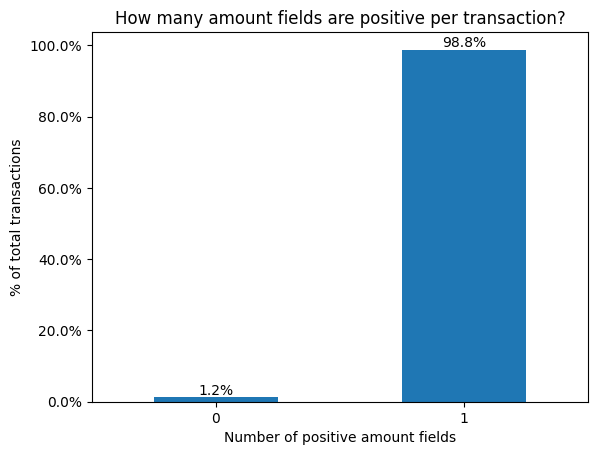

In [22]:
# investigate revenue types
# here I check for each transaction if revenue, cashout or earning is positive
# if the transactions are trully disjoint there should be only 1 True per row

sql_transaction_types = """
select revenue_amount > 0 as positive_revenue,
  cashout_amount > 0 as positive_cashout,
  earning_amount > 0 as positive_earning
from justplay_joined_data
"""

df_transaction_types = ddb_con.execute(sql_transaction_types).fetchdf()

df_transaction_types_check = (
  df_transaction_types.assign(
      n_positives = lambda d: d[["positive_revenue", "positive_cashout", "positive_earning"]].sum(axis = 1)
    )
)

df_transactions_summary = (
  df_transaction_types_check
      .groupby(['positive_revenue', 'positive_cashout', 'positive_earning'], as_index = False)
      .size()
      .rename(columns = {'size': 'n'})
)

df_transactions_summary

transactions_check = df_transaction_types_check["n_positives"].value_counts(normalize = True).sort_index()

trans_plot = transactions_check.plot(kind = "bar")
for i, v in enumerate(transactions_check):
    plt.text(i, v, f"{v*100:.1f}%", ha = "center", va = "bottom")
plt.xlabel("Number of positive amount fields")
plt.xticks(rotation = 0, ha = "center")
plt.ylabel("% of total transactions")
plt.title("How many amount fields are positive per transaction?")
plt.gca().yaxis.set_major_formatter(lambda x, pos: f"{x*100:.1f}%")
plt.show()

# conclusions:
# - almost 99% records register only a type of transaction;
# - about 1% do not register any transatcion (missing values)

In [23]:

# cleaning joined data
# data cleansing process
# - excluded users that weren't activated into the test;
# - there is no unique identifier of transactions as mentioned in metadata
#   (I made prior checks to make sure transactions are unique and disjoint);
# - exluded missing values for amount fields (revenue, cashout or earning);
# - aggregated rows summing the respective amounts (revenue, cashout or earning)

sql_revenue_clean_data = """
create or replace table justplay_revenue_clean_data as
(
select user_id,
  group_id,
  country_code,
  install_dt,
  assignment_dt,
  cast(activated as bool) as activated,
  created_at as transaction_dt,
  revenue_type,
  ad_unit_format,
  sum(revenue_amount) as revenue_amount,
  sum(earning_amount) as earning_amount,
  sum(cashout_amount) as cashout_amount
from justplay_joined_data
where activated != 0
  and (revenue_amount > 0 or cashout_amount > 0 or earning_amount > 0)
group by 1, 2, 3, 4, 5, 6, 7, 8, 9
)
"""

ddb_con.execute(sql_revenue_clean_data)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

# Metric Evaluation

## 1. Retention

Retention is essentially a measure of the rate at which a user returns to the platform. One would expect that users who return more often can generate more value than users who churned away shortly after their first visit (this is not always the case, but it's common domain knowledge).

<br>

For that reason, I strongly believe that looking at retention first can help better understand how other metrics are affected, since they technically depend on users retention.

<br>

Starting with the retention per cohort (cohorts defined by their install date), it's possible to observe that there are no obvious anomalies: looking at the chart with relative differences in retention per cohort, the variability throughout the cohorts does not show any concerning trend.   

In [24]:
sql_retention_cohorts = """
with users_data as
  (
  select distinct group_id,
    user_id,
    install_dt,
    created_at as activity_dt,
    date_diff('day', install_dt, created_at) as days_since_install
  from justplay_joined_data
  where assigned != 0
    and assignment_dt >= install_dt
  ),

cohort_counts as
  (
  select group_id,
    install_dt,
    days_since_install,
    count(distinct user_id) as n_users
  from users_data
  group by 1, 2, 3
  )

select *,
  n_users / day_0_users as retention_rate
from
  (
  select *,
    sum(case when days_since_install == 0 then n_users else 0 end) over(partition by group_id, install_dt) as day_0_users
  from cohort_counts
  )
order by 1, 2, 3
"""

df_retention_cohorts = ddb_con.execute(sql_retention_cohorts).fetchdf()

df_retention_cohorts

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,group_id,install_dt,days_since_install,n_users,day_0_users,retention_rate
0,A: default (control),2025-01-16,0,2787,2787.0,1.000000
1,A: default (control),2025-01-16,1,1314,2787.0,0.471475
2,A: default (control),2025-01-16,2,734,2787.0,0.263366
3,A: default (control),2025-01-16,3,616,2787.0,0.221026
4,A: default (control),2025-01-16,4,505,2787.0,0.181198
...,...,...,...,...,...,...
8545,E: Nd30_Order,2025-03-12,0,2556,2556.0,1.000000
8546,E: Nd30_Order,2025-03-12,1,1311,2556.0,0.512911
8547,E: Nd30_Order,2025-03-12,<NA>,487,2556.0,0.190532
8548,E: Nd30_Order,2025-03-13,0,1372,1372.0,1.000000


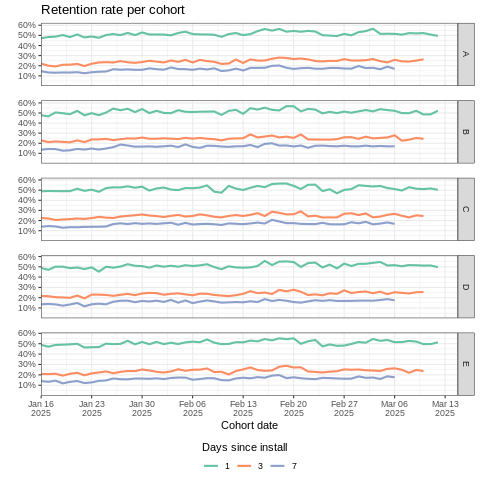

In [25]:
%%R -i df_retention_cohorts

df_retention_cohorts |>
  mutate(days_since_install = factor(days_since_install)) |>
  filter(days_since_install %in% c(1, 3, 7)) |>
  ggplot(aes(x = as.Date(install_dt), y = retention_rate, group = interaction(group_id, days_since_install))) +
    geom_line(aes(color = days_since_install),
              linewidth = 1) +
    facet_grid(sub(":.*", "", group_id) ~., scales = "free") +
    scale_x_date(name = "Cohort date",
                 date_breaks = "7 days",
                 date_labels = "%b %d\n%Y",
                 expand = expansion(add = 0, mult = c(0, 0.05))) +
    scale_y_continuous(name = "",
                       labels = percent,
                       breaks = seq(0.1, 1, 0.1),
                       minor_breaks = seq(0, 1, 0.05),
                       expand = expansion(add = 0, mult = c(0, 0.1))) +
    expand_limits(y = 0) +
    scale_color_discrete(name = "Days since install", palette = "Set2") +
    ggtitle(label = "Retention rate per cohort") +
    theme_bw() +
    theme(panel.spacing = unit(1, "lines"),
          legend.position = "bottom",
          legend.title.position = "top",
          legend.margin = margin())

In [26]:
# observing the differences in retention per cohort can show potential anomalies
# that result from differences in the inflow of new users

mask_control = df_retention_cohorts['group_id'].str.startswith('A')

control = (
      df_retention_cohorts
      .loc[mask_control, ['group_id', 'install_dt', 'days_since_install', 'retention_rate']]
      .rename(columns = {'retention_rate': 'ret_control'})
)

df_retention_cohorts_diff = (
    df_retention_cohorts
    .rename(columns = {'retention_rate': 'ret'})
    .merge(control, on = ['install_dt', 'days_since_install'], how = 'left')
    .assign(ret_diff = lambda d: (d['ret'] - d['ret_control']) / d['ret_control'])
    .rename(columns = {'group_id_x': 'group_id'})
    .drop(columns = 'group_id_y')
)

df_retention_cohorts_diff

,group_id,install_dt,days_since_install,n_users,day_0_users,ret,ret_control,ret_diff
0,A: default (control),2025-01-16,0,2787,2787.0,1.000000,1.000000,0.000000
1,A: default (control),2025-01-16,1,1314,2787.0,0.471475,0.471475,0.000000
2,A: default (control),2025-01-16,2,734,2787.0,0.263366,0.263366,0.000000
3,A: default (control),2025-01-16,3,616,2787.0,0.221026,0.221026,0.000000
4,A: default (control),2025-01-16,4,505,2787.0,0.181198,0.181198,0.000000
...,...,...,...,...,...,...,...,...
8545,E: Nd30_Order,2025-03-12,0,2556,2556.0,1.000000,1.000000,0.000000
8546,E: Nd30_Order,2025-03-12,1,1311,2556.0,0.512911,0.495309,0.035537
8547,E: Nd30_Order,2025-03-12,<NA>,487,2556.0,0.190532,0.181392,0.050390
8548,E: Nd30_Order,2025-03-13,0,1372,1372.0,1.000000,1.000000,0.000000


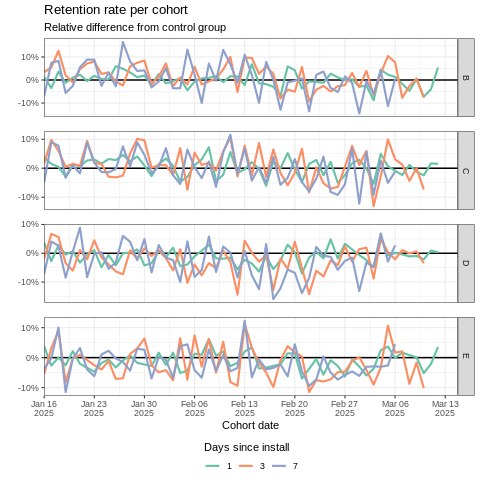

In [27]:
%%R -i df_retention_cohorts_diff

df_retention_cohorts_diff |>
  filter(!str_detect(group_id, "A:")) |>
  mutate(days_since_install = factor(days_since_install)) |>
  filter(days_since_install %in% c(1, 3, 7)) |>
  ggplot(aes(x = as.Date(install_dt), y = ret_diff, group = interaction(group_id, days_since_install))) +
    geom_hline(yintercept = 0, color = "black", linewidth = 0.7) +
    geom_line(aes(color = days_since_install),
              linewidth = 1) +
    facet_grid(sub(":.*", "", group_id) ~., scales = "free") +
    scale_x_date(name = "Cohort date",
                 date_breaks = "7 days",
                 date_labels = "%b %d\n%Y",
                 expand = expansion(add = 0, mult = c(0, 0.05))) +
    scale_y_continuous(name = "",
                       labels = percent,
                       breaks = seq(-1, 1, 0.1),
                       minor_breaks = seq(-1, 1, 0.05),
                       expand = expansion(add = 0, mult = c(0.05, 0.05))) +
    expand_limits(y = 0) +
    scale_color_discrete(name = "Days since install", palette = "Set2") +
    ggtitle(label = "Retention rate per cohort",
            subtitle = "Relative difference from control group") +
    theme_bw() +
    theme(panel.spacing = unit(1, "lines"),
          legend.position = "bottom",
          legend.title.position = "top",
          legend.margin = margin())

In [28]:
sql_retention = """
with users_data as
  (
  select distinct group_id,
    user_id,
    install_dt,
    created_at as activity_dt,
    date_diff('day', install_dt, created_at) as days_since_install
  from justplay_joined_data
  where assigned != 0
    and assignment_dt >= install_dt
  ),

day_counts as
  (
  select group_id,
    days_since_install,
    count(distinct user_id) as n_users
  from users_data
  group by 1, 2
  )

select *,
  n_users / day_0_users as retention_rate
from
  (
  select *,
    sum(case when days_since_install == 0 then n_users else 0 end) over(partition by group_id) as day_0_users
  from day_counts
  )
order by 1, 2
"""

df_retention = ddb_con.execute(sql_retention).fetchdf()

df_retention

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,group_id,days_since_install,n_users,day_0_users,retention_rate
0,A: default (control),0,147985,147985.0,1.000000
1,A: default (control),1,75115,147985.0,0.507585
2,A: default (control),2,43011,147985.0,0.290644
3,A: default (control),3,33963,147985.0,0.229503
4,A: default (control),4,29250,147985.0,0.197655
...,...,...,...,...,...
285,E: Nd30_Order,53,405,147422.0,0.002747
286,E: Nd30_Order,54,298,147422.0,0.002021
287,E: Nd30_Order,55,188,147422.0,0.001275
288,E: Nd30_Order,56,110,147422.0,0.000746


<br>

Looking at the overall retention curve (this time disregarding the cohort dimension) it's possible to see how most groups in the experiment overlap - which is evidence that if there are any statistically significant differences, these are probably small in size and not relevant in a business context.

<br>



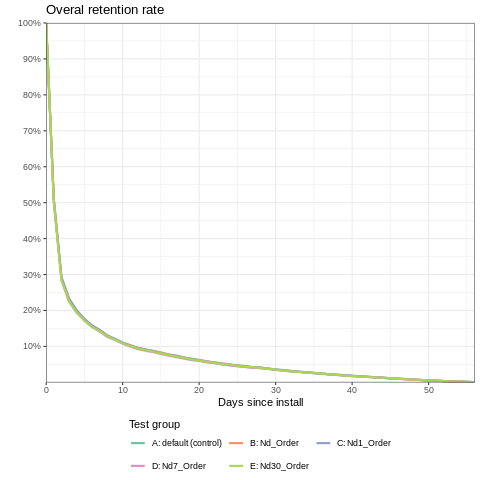

In [29]:
%%R -i df_retention

options(warnings = -1)

df_retention |>
  filter(!is.na(days_since_install)) |>
  ggplot(aes(x = days_since_install, y = retention_rate, group = group_id)) +
    geom_line(aes(color = group_id),
              linewidth = 1) +
    scale_x_continuous(name = "Days since install",
                       expand = c(0, 0)) +
    scale_y_continuous(name = "",
                       labels = percent,
                       breaks = seq(0.1, 1, 0.1),
                       minor_breaks = seq(0, 1, 0.05),
                       expand = c(0, 0)) +
    expand_limits(y = 0) +
    scale_color_brewer(name = "Test group", palette = "Set2") +
    ggtitle(label = "Overal retention rate") +
    guides(color = guide_legend(nrow = 2, byrow = TRUE)) +
    theme_bw() +
    theme(legend.position = "bottom",
          legend.title.position = "top",
          legend.margin = margin())

<br>

In order to assess the statistical significance of differences in retention rates, a set of pairwise two-sample z-tests on proportions is performed (N x D tests, with N = number of experimental groups and D = number of retention days in analysis). The hypotheses in test are

$H_0: RetD_{i,k} = RetD_{i, A}$

$H_1: RetD_{i,k} \not= RetD_{i, A}$,

with $i = 1, 2, ..., D$ retention days

and $k ∈ \{B, C, D, E\}$ experimental groups.

<br>

Note: p-values are adjusted using Holm's correction (Family-Wise Error Rate) to control for false positives.


In [30]:
# quantify relative difference in retention
# that result from differences in the inflow of new users

mask_control = df_retention['group_id'].str.startswith('A')

control = (
    df_retention
      .loc[mask_control, ['group_id', 'days_since_install', 'retention_rate']]
      .rename(columns={'retention_rate': 'ret_control'})
)

df_retention_diff = (
  df_retention
    .rename(columns={'retention_rate': 'ret'})
    .merge(control, on=['days_since_install'], how='left')
    .assign(ret_diff=lambda d: (d['ret'] - d['ret_control']) / d['ret_control'])
    .rename(columns={'group_id_x': 'group_id'})
    .drop(columns='group_id_y')
)

control_counts = (
  df_retention_diff
    .loc[df_retention_diff['group_id'].str.startswith('A'),
         ['days_since_install', 'n_users', 'day_0_users']]
    .rename(columns={
        'n_users': 'n_users_control',
        'day_0_users': 'day_0_users_control'
    })
)

df_retention_tests = (
  df_retention_diff
    .merge(control_counts, on='days_since_install', how='left')
)

def test_row(r, control_string='A:'):
    if r['group_id'].startswith(control_string):
        return pd.Series({'z_stat': np.nan, 'p_value': np.nan})

    n = [r['n_users'], r['n_users_control']]
    n_all = [r['day_0_users'], r['day_0_users_control']]

    z, p = proportions_ztest(count=n, nobs=n_all, alternative="two-sided")
    return pd.Series({'z_stat': z, 'p_value': p})

df_retention_tests = (
  df_retention_tests
    .join(df_retention_tests.apply(test_row, axis=1))
)

# itialize p_adj column (all are NaN, then we will populate it with values)
df_retention_tests['p_adj'] = np.nan

# apply Holm-correction per day, across the test groups
for day in df_retention_tests['days_since_install'].unique():
    mask = (
        (df_retention_tests['days_since_install'] == day) &
        (~df_retention_tests['group_id'].str.startswith('A:'))
    )

    pvals = df_retention_tests.loc[mask, 'p_value']

    if pvals.isna().all():
        continue

    _, pvals_adj, _, _ = multipletests(pvals, method='holm')
    df_retention_tests.loc[mask, 'p_adj'] = pvals_adj

# if p_adj is smaller than significance threshold (0.05) mark as not significant
df_retention_tests = (
    df_retention_tests
      .assign(stat_sign = lambda d: np.where(d['p_adj'] < 0.05, 'p < 0.05', 'not sign.'))
)

df_retention_tests

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std


,group_id,days_since_install,n_users,day_0_users,ret,ret_control,ret_diff,n_users_control,day_0_users_control,z_stat,p_value,p_adj,stat_sign
0,A: default (control),0,147985,147985.0,1.000000,1.000000,0.000000,147985,147985.0,NaN,NaN,NaN,not sign.
1,A: default (control),1,75115,147985.0,0.507585,0.507585,0.000000,75115,147985.0,NaN,NaN,NaN,not sign.
2,A: default (control),2,43011,147985.0,0.290644,0.290644,0.000000,43011,147985.0,NaN,NaN,NaN,not sign.
3,A: default (control),3,33963,147985.0,0.229503,0.229503,0.000000,33963,147985.0,NaN,NaN,NaN,not sign.
4,A: default (control),4,29250,147985.0,0.197655,0.197655,0.000000,29250,147985.0,NaN,NaN,NaN,not sign.
...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,E: Nd30_Order,53,405,147422.0,0.002747,0.002595,0.058715,384,147985.0,0.802227,0.422422,1.000000,not sign.
286,E: Nd30_Order,54,298,147422.0,0.002021,0.001818,0.112037,269,147985.0,1.264483,0.206057,0.555543,not sign.
287,E: Nd30_Order,55,188,147422.0,0.001275,0.001264,0.009187,187,147985.0,0.088603,0.929398,1.000000,not sign.
288,E: Nd30_Order,56,110,147422.0,0.000746,0.000791,-0.056239,117,147985.0,-0.436060,0.662793,0.836012,not sign.


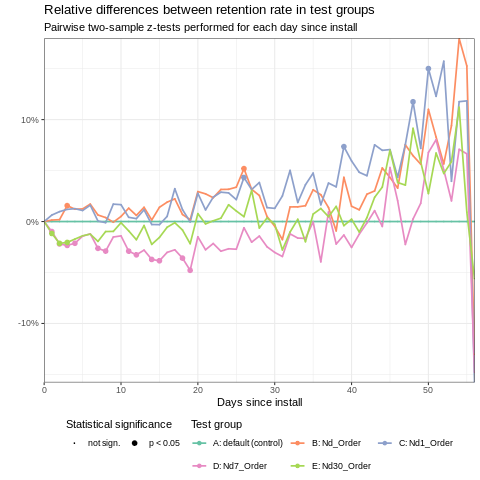

In [31]:
%%R -i df_retention_tests

options(warnings = -1)

df_retention_tests |>
  filter(!is.na(days_since_install)) |>
  ggplot(aes(x = days_since_install, y = ret_diff, group = group_id)) +
    geom_line(aes(color = group_id),
              linewidth = 0.8) +
    geom_point(aes(color = group_id, size = stat_sign)) +
    scale_x_continuous(name = "Days since install",
                       expand = c(0, 0)) +
    scale_y_continuous(name = "",
                       labels = percent,
                       breaks = seq(-1, 1, 0.1),
                       minor_breaks = seq(-1, 1, 0.05),
                       expand = c(0, 0)) +
    expand_limits(y = 0) +
    scale_color_brewer(name = "Test group", palette = "Set2") +
    scale_size_manual(name = "Statistical significance",
                       values = c("p < 0.05" = 2, "not sign." = 0)) +
    ggtitle(label = "Relative differences between retention rate in test groups",
            subtitle = "Pairwise two-sample z-tests performed for each day since install") +
    guides(color = guide_legend(nrow = 2, byrow = TRUE)) +
    theme_bw() +
    theme(legend.position = "bottom",
          legend.title.position = "top",
          legend.margin = margin())

<br>

The results of the statistical tests show that for most of the cases there are no significant changes in retention rates between experimental groups and control.

<br>

Only group D consistently shows significant differences (for the most days up to the 20th day of the experiment), with these differences ranging between -1% to -5% (lower) than the control group.

<br>

Conclusion: solely based on retention metrics, and without any knowledge about revenue impact, I **would not recommend the adoption of any of these variants** into production.



## 2. Proportion of users with Positive Net Revenue

I'll first investigate if this experiment resulted in a larger pool of profitable users, in other words, if any of the test groups has a higher proportion of users with a Positive Net Revenue (PNR). For that, I set the following null hypothesis

$H_0: 𝑃𝑟𝑜𝑝𝑜𝑟𝑡𝑖𝑜𝑛^{PNR}_𝑋 = 𝑃𝑟𝑜𝑝𝑜𝑟𝑡𝑖𝑜𝑛^{PNR}_𝐴$

and given that we are interested into superiority scenarios (where the proportion of users with PNR is bigger than in the control group), the alternative hypothesis is defined as

$H_1: 𝑃𝑟𝑜𝑝𝑜𝑟𝑡𝑖𝑜𝑛^{PNR}_𝑋 > 𝑃𝑟𝑜𝑝𝑜𝑟𝑡𝑖𝑜𝑛^{PNR}_𝐴$.

<br>
Analysis breakdown:

1. the first step is to calculate the net revenue for each user, aggregating all revenue generated, as well as the payouts and computing the difference;
2. then I'll proceed to identify users with a positive net revenue, those with a non-positive net revenue and the total observations per group;
3. finally the **one-sided two-sample z-test for proportions** is performed, and the relative differences in proportions calculated.

In [32]:
# revenue query
sql_net_revenue = """
select group_id,
  user_id,
  sum(revenue_amount - cashout_amount) as net_revenue
from justplay_revenue_clean_data
group by 1, 2
"""

df_net_revenue = ddb_con.execute(sql_net_revenue).fetchdf()

df_net_revenue

,group_id,user_id,net_revenue
0,D: Nd7_Order,0e12fd0d-7a02-406c-9c13-d2bcef666819,2.754482
1,B: Nd_Order,0e130a5e-5a39-45a0-9940-3849be2779be,0.687811
2,B: Nd_Order,0e13136a-bb53-4200-a175-656675e96163,0.484765
3,C: Nd1_Order,0e134785-124e-48a3-89e1-658b250065fb,1.067203
4,C: Nd1_Order,0e135988-2736-47d2-ba54-fd872a5d7aef,0.105000
...,...,...,...
795024,E: Nd30_Order,ff182433-24f3-4ac2-93cc-b7d4cbbc19f0,0.000000
795025,D: Nd7_Order,ff1835f1-de8a-4808-b02d-c5844367225d,0.000000
795026,A: default (control),ff18b478-a16f-44b7-bb9e-294a68c86587,0.000000
795027,B: Nd_Order,ff1cf45b-53a4-49b0-9c04-724485c24435,0.000000


In [33]:
from pandas.core.reshape.pivot import crosstab

# check if users have a positive net revenue or not
# count users that have a positive net revenue
# count users that have a non-positive net revenue
# compute total users per group
# calculate proportion of users with positive net revenue

df_net_revenue_prop = (
    pd.crosstab(
        df_net_revenue['group_id'],
        df_net_revenue['net_revenue'] > 0
    )
    .rename(columns = {True: 'positive', False: 'not_positive'})
    .assign(total_users = lambda d: d['positive'] + d['not_positive'])
    .assign(prop = lambda d: d['positive'] / d['total_users'])
    .reset_index()
)

df_net_revenue_prop

net_revenue,group_id,not_positive,positive,total_users,prop
0,A: default (control),34639,124714,159353,0.782627
1,B: Nd_Order,34072,125494,159566,0.786471
2,C: Nd1_Order,34416,124268,158684,0.783116
3,D: Nd7_Order,35355,123151,158506,0.776949
4,E: Nd30_Order,35179,123741,158920,0.778637


In [34]:
# identify groups as control of experiment (if control then 'True')
# isolate control group row into a vector
# this way we can iterate over all rows and perform the z-test

mask_control = df_net_revenue_prop['group_id'].str.startswith('A')
control_row = df_net_revenue_prop.loc[mask_control].iloc[0]

df_z_test = (
    df_net_revenue_prop#.loc[~mask_control]
    .assign(
      z_p = lambda d: d.apply(
          lambda row: proportions_ztest(
              count = [row['positive'], control_row['positive']],
              nobs = [row['total_users'], control_row['total_users']],
              alternative = 'larger'
          ),
          axis = 1
        )
      )
  )


# split the (z, p) tuples into separate columns and drop the old column
df_z_test[['z_stat', 'p_value']] = pd.DataFrame(df_z_test['z_p'].tolist(), index = df_z_test.index)
df_z_test = df_z_test.drop(columns = ['z_p'])

# include p-value correction against false discovery rate (FDR)
# nice article on this topic: https://pmc.ncbi.nlm.nih.gov/articles/PMC6099145/
df_z_test["p_adj"] = multipletests(df_z_test["p_value"], method = "fdr_bh")[1]

# finally calculate the relative difference in proportions against the control
df_z_test = df_z_test.assign(prop_diff = lambda d: (d['prop'] - control_row['prop']) / control_row['prop'])

df_z_test.loc[df_z_test["group_id"].str.startswith("A"), ['z_stat', 'p_value', 'p_adj']] = np.nan
df_z_test

net_revenue,group_id,not_positive,positive,total_users,prop,z_stat,p_value,p_adj,prop_diff
0,A: default (control),34639,124714,159353,0.782627,NaN,NaN,NaN,0.000000
1,B: Nd_Order,34072,125494,159566,0.786471,2.639731,0.004149,0.020743,0.004911
2,C: Nd1_Order,34416,124268,158684,0.783116,0.334355,0.369056,0.833333,0.000625
3,D: Nd7_Order,35355,123151,158506,0.776949,-3.863086,0.999944,0.999944,-0.007256
4,E: Nd30_Order,35179,123741,158920,0.778637,-2.719921,0.996735,0.999944,-0.005098


**Statistical analysis**

The one-sided z-test shows that only the experimental Group B has a significantly higher proportion of users generating a positive net revenue (78.6%) against the control group (78.3%). With an adjusted p-value such as $ p_{adj}≈ 0.02 < 0.05$ the null hypothesis is rejected (i.e., there's evidence of a higher ratio of profitable users in Group B).

<br>

Looking at other groups, we can tell that Group C doesn't show any evidence that allows us to reject the null hypothesis, meanwhile groups D and E show very high p-values alongside strongly negative values for the z-stat, supporting evidence that the result contradicts the one-sided alternative hypothesis.


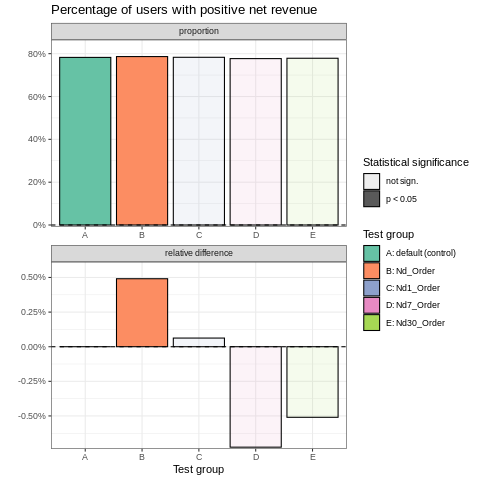

In [35]:
%%R -i df_z_test

df_z_test |>
  select(group_id, p_value, prop, prop_diff) |>
  rename(proportion = prop,
         `relative difference` = prop_diff) |>
  gather(-c(group_id, p_value), key = metric, value = value) |>
  mutate(stat_sig = ifelse(p_value < 0.05 | is.na(p_value) , "p < 0.05", "not sign.")) |>
  ggplot(aes(x = group_id, y = value)) +
    geom_bar(aes(fill = group_id, alpha = stat_sig),
             stat = "identity", color = "black") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
    facet_wrap(metric ~ ., nrow = 2, scales = "free", strip.position = "top") +
    scale_x_discrete(name = "Test group",
                     labels = function(x) sub(":.*", "", x)) +
    scale_y_continuous(name = "",
                       labels = percent,
                       expand = expansion(mult = c(0.01, 0.1))) +

    expand_limits(y = 0) +
    scale_fill_brewer(name = "Test group", palette = "Set2") +
    scale_alpha_manual(name = "Statistical significance",
                       values = c("p < 0.05" = 1, "not sign." = 0.1)) +
    ggtitle(label = "Percentage of users with positive net revenue") +
    theme_bw()

## 3. Net Revenue per user

As suggested, the Net Revenue consists of the total revenue generated by a user, deducted from any cashouts those users got paid. In short, this is a measure of user profitability.

<br>

As expected, after some exploratory analysis it's possible to confirm that the net revenue is zero-inflated and highly (right) skewed and thus violating normality assumptions. With that in mind, parametric tests will not be useful to answer if the net revenue per user in experimental groups differs from control.



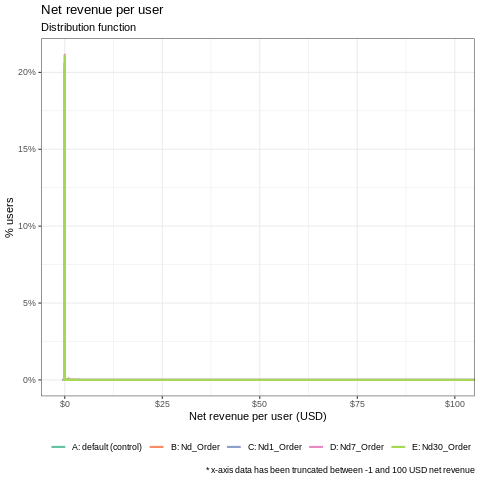

In [36]:
%%R -i df_net_revenue

df_net_revenue |>
  group_by(group_id, net_revenue) |>
  summarize(unique_users = n_distinct(user_id), .groups = "drop") |>
  group_by(group_id) |>
  mutate(total_users = sum(unique_users)) |>
  mutate(percent = unique_users / total_users) |>
  ungroup() |>
  ggplot(aes(x = net_revenue, color = group_id)) +
    geom_line(aes(y = percent), linewidth = 1) +
    scale_x_continuous(name = "Net revenue per user (USD)", labels = dollar) +
    scale_y_continuous(name = "% users",labels = percent) +
    scale_color_brewer(palette = "Set2", name = "") +
    coord_cartesian(xlim = c(-1, 100)) +
    ggtitle(label = "Net revenue per user",
            subtitle = "Distribution function") +
    labs(caption = "* x-axis data has been truncated between -1 and 100 USD net revenue") +
    theme_bw() +
    theme(legend.position = "bottom")

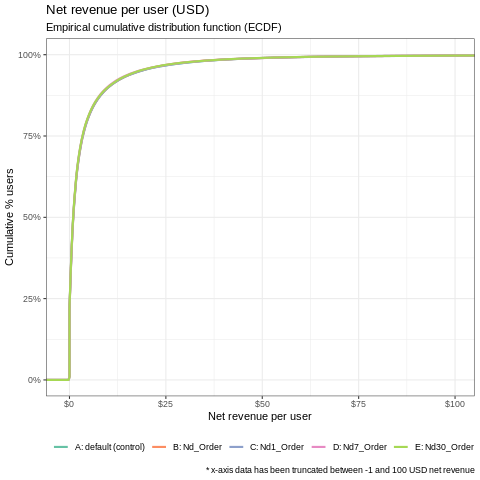

In [37]:
%%R -i df_net_revenue

df_net_revenue |>
  ggplot(aes(x = net_revenue, color = group_id)) +
    stat_ecdf(linewidth = 1) +
    scale_x_continuous(name = "Net revenue per user", labels = dollar) +
    scale_y_continuous(name = "Cumulative % users",labels = percent) +
    scale_color_brewer(palette = "Set2", name = "") +
    coord_cartesian(xlim = c(-1, 100)) +
    ggtitle(label = "Net revenue per user (USD)",
            subtitle = "Empirical cumulative distribution function (ECDF)") +
    labs(caption = "* x-axis data has been truncated between -1 and 100 USD net revenue") +
    theme_bw() +
    theme(legend.position = "bottom")

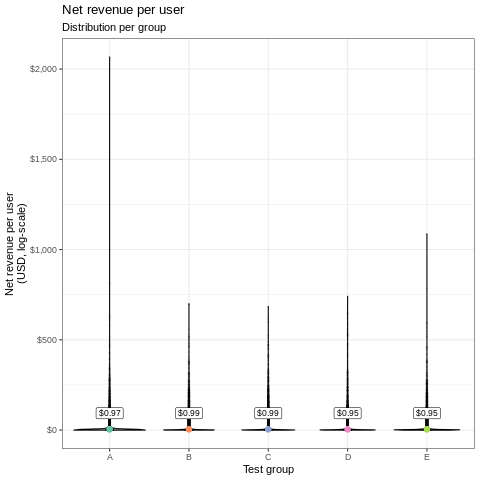

In [38]:
%%R -i df_net_revenue

options(warn = -1)

df_net_revenue_summary <-
  df_net_revenue |>
  group_by(group_id) |>
  summarise(median_revenue = median(net_revenue, na.rm = TRUE),
            avg_revenue = mean(net_revenue, na.rm = TRUE),
            .groups = "drop")

df_net_revenue |>
  ggplot(aes(x = group_id, y = net_revenue, fill = group_id)) +
    geom_violin(trim = TRUE, alpha = 0.3, color = "black") +
    geom_boxplot(color = "black", alpha = 0.3,
                 outlier.alpha = 0.1, width = 0.1, outlier.size = 0.5) +
    geom_point(data = df_net_revenue_summary,
               aes(x = group_id, y = avg_revenue, color = group_id),
               size = 2.5, inherit.aes = FALSE) +
    geom_label(data = df_net_revenue_summary,
               aes(x = group_id, y = median_revenue, label = dollar(median_revenue)),
               vjust = -1, size = 3, inherit.aes = FALSE) +
    scale_x_discrete(name = "Test group", labels = function(x) sub(":.*", "", x)) +
    scale_y_continuous(name = "Net revenue per user\n(USD, log-scale)",labels = dollar) +
    scale_color_brewer(name = "", palette = "Set2") +
    scale_fill_brewer(name = "", palette = "Set2") +
    #coord_cartesian(xlim = c(-1, 100)) +
    ggtitle(label = "Net revenue per user",
            subtitle = "Distribution per group") +
    theme_bw() +
    theme(legend.position = "none")

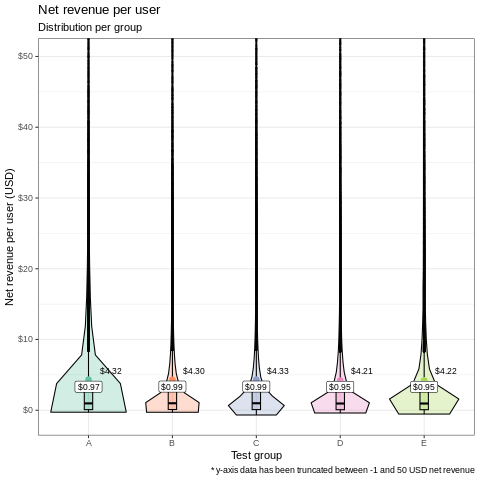

In [39]:
%%R -i df_net_revenue

options(warn = -1)

df_net_revenue_summary <-
  df_net_revenue |>
  group_by(group_id) |>
  summarise(median_revenue = median(net_revenue, na.rm = TRUE),
            avg_revenue = mean(net_revenue, na.rm = TRUE),
            .groups = "drop")

df_net_revenue |>
  ggplot(aes(x = group_id, y = net_revenue, fill = group_id)) +
    geom_violin(trim = TRUE, alpha = 0.3, color = "black") +
    geom_boxplot(width = 0.1, color = "black", alpha = 0.3,
                 outlier.alpha = 0.1, outlier.size = 0.5) +
    geom_point(data = df_net_revenue_summary,
              aes(x = group_id, y = avg_revenue, color = group_id),
              size = 2.5, inherit.aes = FALSE) +
    geom_label(data = df_net_revenue_summary,
              aes(x = group_id, y = median_revenue, label = dollar(median_revenue)),
              vjust = -1, size = 3, inherit.aes = FALSE) +
    geom_text(data = df_net_revenue_summary,
              aes(x = group_id, y = avg_revenue, label = dollar(avg_revenue)),
              vjust = -1, hjust = -0.5, size = 3, inherit.aes = FALSE) +
    scale_x_discrete(name = "Test group", labels = function(x) sub(":.*", "", x)) +
    scale_y_continuous(name = "Net revenue per user (USD)",labels = dollar) +
    scale_color_brewer(name = "", palette = "Set2") +
    scale_fill_brewer(name = "", palette = "Set2") +
    coord_cartesian(ylim = c(-1, 50)) +
    labs(caption = "* y-axis data has been truncated between -1 and 50 USD net revenue") +
    ggtitle(label = "Net revenue per user",
            subtitle = "Distribution per group") +
    theme_bw() +
    theme(legend.position = "none")

The previous violin/boxplot charts show evidences that test groups distributions are visibly different from control. However, it is important to verify if those differences are statistically significant and measure their effect size.

Firstly we can perform the Kruskal-Wallis test to verify if all samples have the same central tendency. For that we define the following hypothesis

$H_0: F_1(x) = F_2(x) = ... = F_k(x)$,  for all x

$H_1: ∃i,j: F_i(x) \not=  F_j(x)$ .

In [40]:
# Kruskal-Wallis test

# ------------------------------ step-by-step ---------------------------------
# 1. rank all users
# 2. in case of ties assign all those records the average for that rank
# 3. calculate each group's rank sums
# 4. calculate each group's mean rank sum
# 5. calculate the expected value of rankings => E = (n+1)/2, n = total users
# 6. degrees of freedom => df = nGroups - 1 = 4
# 7. rank variance => var(rank) = (n^2-1)/12
# 8. calculate H stat
# 9. compare against critical table
# -----------------------------------------------------------------------------

# -------------------- using the SciPy implementation ------------------------
# 1. create an empty list to store group arrays
# 2. extract revenue data from each group and store each of them into an array
# 3. populate/append the groups list with eacha array
# 4. run the Kruskal-Wallis test
# -----------------------------------------------------------------------------


groups = []

for group_name, group_df in df_net_revenue.groupby("group_id"):
  revs = group_df["net_revenue"]
  rev_array = revs.values
  groups.append(rev_array)

kruskal_result = kruskal(*groups)

h_stat = kruskal_result.statistic
p_value = kruskal_result.pvalue

print("Kruskal–Wallis H statistic:", h_stat)
print("p-value:", p_value)

Kruskal–Wallis H statistic: 61.42579271465181
p-value: 1.454770537363596e-12


Given p-value $p ≈ 1.45x10^{-12} < 0.05$ the null hypothesis is rejected, meaning there's statistical evidence that not all groups have the same distribution. However, this test does not provide information about what samples are differently distributed.

<br>

In order to assess if any group shows an increase in the net revenue per user, I will perform **pairwise one-sided Mann-Whitney U tests** between each experimental variant and the control group. Here are the test hypothesis:

$H_0: F_A(x) = F_i(x)$

$H_1: P(X_i > X_A) > 0.5$.

In [41]:
# Mann-Whitney U test

# ----------------------- using the SciPy implementation ----------------------
# 1. identify control and experimental groups
# 2. perform the MWU test and extract U-statistic and raw p-value
# 3. calculate the common language effect size
# 4. calculate Cliff's delta
# 5. store results into a dataframe and append
# 6. correct p-values against false discovery rate (FDR)
# -----------------------------------------------------------------------------

mwu_results = []

control_group = "A: default (control)"
test_groups = [
    g for g in df_net_revenue["group_id"].unique()
    if g != control_group
]

for tg in test_groups:
  # fetch the observations for control and the test group (tg) in analysis
  control_obs = df_net_revenue.loc[df_net_revenue["group_id"] == control_group, "net_revenue"].values
  test_obs = df_net_revenue.loc[df_net_revenue["group_id"] == tg, "net_revenue"].values

  # calculate the number of users in each sample (1 row per user)
  control_users = len(control_obs)
  test_users = len(test_obs)

  # perform the MWU test and extract U-statistic and raw p-value
  res = mannwhitneyu(
      control_obs,
      test_obs,
      alternative = "greater",
      method = "asymptotic") # don't use "exact" for large samples (RIP runtime :3)

  u_stat = res.statistic
  p_value = res.pvalue

  # calculate the common language effect size and Cliff's delta
  cles = u_stat / (control_users * test_users)
  cliffs_delta = (2 * cles) - 1

  # insert all data to results and append
  mwu_results.append({
      "test_group": tg,
      "control_users": control_users,
      "test_users": test_users,
      "u_stat": u_stat,
      "p_value": p_value,
      "cles": cles,
      "cliffs_delta": cliffs_delta
  })

mwu_results = pd.DataFrame(mwu_results)
mwu_results["p_adj"] = multipletests(mwu_results["p_value"], method="fdr_bh")[1]
mwu_results = mwu_results.sort_values("test_group")

mwu_results

,test_group,control_users,test_users,u_stat,p_value,cles,cliffs_delta,p_adj
1,B: Nd_Order,159353,159566,1.264057e+10,0.997626,0.497126,-0.005749,0.997626
2,C: Nd1_Order,159353,158684,1.257948e+10,0.993421,0.497473,-0.005055,0.997626
0,D: Nd7_Order,159353,158506,1.270565e+10,0.001495,0.503026,0.006053,0.005108
3,E: Nd30_Order,159353,158920,1.273443e+10,0.002554,0.502853,0.005705,0.005108


**Conclusion:** Based on the Mann-Whitney U test it's possible to conclude that sample differences from **test groups B and C do not yield statistical significance**. Even though we saw earlier that the percentage of users with a positive net revenue is higher in B (than in control group), we can now conclude that this does not necessarily generate an uplift in net revenue - and this is easy to understand given the heavy tail of the control group, where very high monetary value outliers ("whales") skew the average net revenue as well.

The adjusted p-values of groups D and E are similar with $p_{adj} ≈ 0.005 < 0.05$ which leads to the rejection of the null hypothesis in both cases. However, the effect sizes observed in those samples are negligible (approximately $≈0.006$ for both cases). In conclusion: a random user of either groups D (or E) is only about 0.6% more likely to generate more (net) revenue than a user in control group.

## 4. Impact over different ad formats

While the several variants do not seem to "move the needle" sufficiently for me to recommend their adoption, it's still important to understand the effect of experiments like such into the various revenue streams such as the different ad formats (banners, interstitials and rewarded videos).

<br>

Note that the data about different ad formats is only available for advertising through AppLovin - and even though this partner represents about 60% of total impressions, conclusions might not hold true for other networks.



In [42]:
sql_impressions_applovin = """
  select
    sum(if(ad_unit_format != 'missing', 1, 0)) as applovin_imps,
    sum(1) as all_imps,
    sum(if(ad_unit_format != 'missing', 1, 0)) / sum(1) as applovin_imps_share
  from justplay_revenue_clean_data
"""

df_impressions_applovin = ddb_con.execute(sql_impressions_applovin).fetchdf()

df_impressions_applovin

,applovin_imps,all_imps,applovin_imps_share
0,6809232.0,11253739.0,0.605064


In [43]:
sql_impressions_per_format = """
select group_id,
  user_id,
  ad_unit_format,
  sum(1) as impressions
from justplay_revenue_clean_data
where ad_unit_format != 'missing'
group by 1, 2, 3
"""

df_impressions_per_format = ddb_con.execute(sql_impressions_per_format).fetchdf()

df_impressions_per_format

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,group_id,user_id,ad_unit_format,impressions
0,E: Nd30_Order,0e12f234-d654-4728-a07d-1ff8b15033f2,inter,49.0
1,E: Nd30_Order,0e12f234-d654-4728-a07d-1ff8b15033f2,reward,49.0
2,C: Nd1_Order,0e134785-124e-48a3-89e1-658b250065fb,inter,2.0
3,B: Nd_Order,0e138fbd-5d48-4a14-a454-430764743949,banner,11.0
4,D: Nd7_Order,0e13f37e-4775-41ee-a4fc-9d163ec08b68,inter,1.0
...,...,...,...,...
1519726,A: default (control),ff1df1e6-2984-4d1f-bb6d-5f74e7392bb8,banner,2.0
1519727,C: Nd1_Order,ff1e18e5-636e-449d-89bb-ab241806f703,inter,1.0
1519728,A: default (control),ff1e19c4-cc03-41e0-b113-b45bccee554a,inter,1.0
1519729,C: Nd1_Order,ff1e2d18-e73d-4fd2-a186-e91be1f610e5,reward,1.0


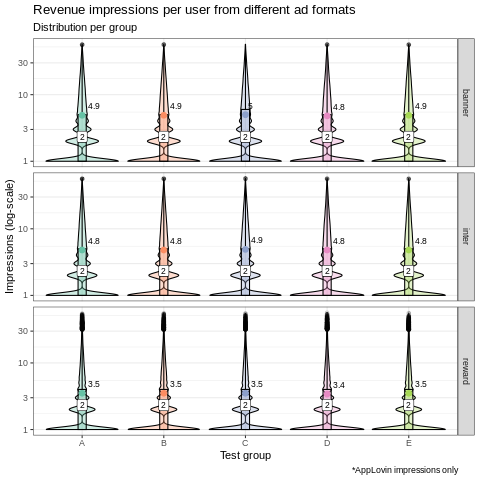

In [44]:
%%R -i df_impressions_per_format

options(warn = -1)

df_impressions_per_format_summary <-
  df_impressions_per_format |>
  group_by(group_id, ad_unit_format) |>
  summarise(median_impressions = round(median(impressions, na.rm = TRUE), 1),
            avg_impressions = round(mean(impressions, na.rm = TRUE), 1),
            .groups = "drop")

df_impressions_per_format |>
  ggplot(aes(x = group_id, y = impressions, fill = group_id)) +
    geom_violin(trim = TRUE, alpha = 0.3, color = "black") +
    geom_boxplot(color = "black", alpha = 0.3, outlier.alpha = 0.1, width = 0.1) +
    geom_point(data = df_impressions_per_format_summary,
               aes(x = group_id, y = avg_impressions, color = group_id),
               size = 2.5, inherit.aes = FALSE) +
    geom_label(data = df_impressions_per_format_summary,
               aes(x = group_id, y = median_impressions, label = median_impressions),
               vjust = 0.1, size = 3, inherit.aes = FALSE) +
    geom_text(data = df_impressions_per_format_summary,
              aes(x = group_id, y = avg_impressions, label = avg_impressions),
              vjust = -1, hjust = -0.5, size = 3, inherit.aes = FALSE) +
    scale_x_discrete(name = "Test group", labels = function(x) sub(":.*", "", x)) +
    scale_y_log10(name = "Impressions (log-scale)",) +
    scale_color_brewer(name = "", palette = "Set2") +
    scale_fill_brewer(name = "", palette = "Set2") +
    facet_grid(ad_unit_format~., scales = "free") +
    #coord_cartesian(ylim = c(0, 10)) +
    labs(caption = "*AppLovin impressions only") +
    ggtitle(label = "Revenue impressions per user from different ad formats",
            subtitle = "Distribution per group") +
    theme_bw() +
    theme(legend.position = "none")

In [45]:
mwu_results = []

control_group = "A: default (control)"
test_groups = [
    g for g in df_impressions_per_format["group_id"].unique()
    if g != control_group
]

ad_formats = df_impressions_per_format["ad_unit_format"].unique()

# the test will be performed comparing each group vs control, one ad format at a time
for ad_format in ad_formats:

    # fetch control observations for this ad_format
    control_obs = df_impressions_per_format.loc[
        (df_impressions_per_format["group_id"] == control_group) &
        (df_impressions_per_format["ad_unit_format"] == ad_format),
        "impressions"
    ].values

    control_users = len(control_obs)

    for tg in test_groups:

        # fetch test-group observations for this ad_format
        test_obs = df_impressions_per_format.loc[
            (df_impressions_per_format["group_id"] == tg) &
            (df_impressions_per_format["ad_unit_format"] == ad_format),
            "impressions"
        ].values

        test_users = len(test_obs)

        # skip if one of them is empty (no users for that format/group)
        if control_users == 0 or test_users == 0:
            continue

        # perform the MWU test and extract U-statistic and raw p-value
        res = mannwhitneyu(
            control_obs,
            test_obs,
            alternative = "greater",
            method = "asymptotic"  # don't use "exact" for large samples (RIP runtime :3)
        )

        u_stat = res.statistic
        p_value = res.pvalue

        # calculate the common language effect size and Cliff's delta
        cles = u_stat / (control_users * test_users)
        cliffs_delta = (2 * cles) - 1

        # insert all data to results and append
        mwu_results.append({
            "ad_format": ad_format,
            "test_group": tg,
            "control_users": control_users,
            "test_users": test_users,
            "u_stat": u_stat,
            "p_value": p_value,
            "cles": cles,
            "cliffs_delta": cliffs_delta
        })

mwu_results = pd.DataFrame(mwu_results)

# initialize adjusted p-values as NaN (populate later)
mwu_results["p_adj"] = np.nan

# FDR correction per ad_format (4 tests per format)
for ad_format in ad_formats:
    mask = mwu_results["ad_format"] == ad_format
    if mask.sum() == 0:
        continue
    pvals = mwu_results.loc[mask, "p_value"]
    mwu_results.loc[mask, "p_adj"] = multipletests(pvals, method = "fdr_bh")[1]

mwu_results = (
  mwu_results
  .sort_values(["ad_format", "test_group"])
  .assign(stat_sign = lambda d: np.where(d['p_adj'] < 0.05, 'p < 0.05', 'not sign.'))
)

mwu_results

,ad_format,test_group,control_users,test_users,u_stat,p_value,cles,cliffs_delta,p_adj,stat_sign
10,banner,B: Nd_Order,108240,109423,5.908274e+09,0.832582,0.498843,-0.002313,0.956642,not sign.
9,banner,C: Nd1_Order,108240,108151,5.829011e+09,0.956642,0.497939,-0.004121,0.956642,not sign.
11,banner,D: Nd7_Order,108240,106300,5.803216e+09,0.000148,0.504368,0.008736,0.000591,p < 0.05
8,banner,E: Nd30_Order,108240,107093,5.842563e+09,0.000413,0.504028,0.008056,0.000826,p < 0.05
2,inter,B: Nd_Order,111142,113373,6.302519e+09,0.439172,0.500180,0.000360,0.585562,not sign.
1,inter,C: Nd1_Order,111142,111198,6.152412e+09,0.967544,0.497818,-0.004365,0.967544,not sign.
3,inter,D: Nd7_Order,111142,109930,6.173385e+09,0.000004,0.505276,0.010553,0.000017,p < 0.05
0,inter,E: Nd30_Order,111142,110190,6.168912e+09,0.000838,0.503719,0.007438,0.001677,p < 0.05
6,reward,B: Nd_Order,86042,84389,3.619016e+09,0.884893,0.498418,-0.003163,0.884893,not sign.
5,reward,C: Nd1_Order,86042,86165,3.722160e+09,0.058090,0.502058,0.004116,0.077453,not sign.


In [46]:
sql_revenue_per_format = """
select group_id,
  user_id,
  ad_unit_format,
  sum(revenue_amount) as revenue_amount
from justplay_revenue_clean_data
where ad_unit_format != 'missing'
group by 1, 2, 3
"""

df_revenue_per_format = ddb_con.execute(sql_revenue_per_format).fetchdf()

df_revenue_per_format

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,group_id,user_id,ad_unit_format,revenue_amount
0,C: Nd1_Order,00001923-dcad-411d-a479-6d5ff1889a5a,banner,0.440742
1,C: Nd1_Order,00001b9a-e945-40e1-a526-ed1f3e303d57,banner,0.798619
2,A: default (control),00003f44-d7e7-40bb-b08e-3fd910d0385d,inter,4.388195
3,A: default (control),00003f44-d7e7-40bb-b08e-3fd910d0385d,reward,1.335318
4,C: Nd1_Order,00004d2a-5575-4e8c-9135-6564304cbab7,banner,0.098017
...,...,...,...,...
1519726,C: Nd1_Order,ff1d4568-369f-4d2b-8ede-96c06eab98cd,reward,0.422967
1519727,E: Nd30_Order,ff1d50bf-2b0b-44ca-865e-4c7de053697d,banner,0.001874
1519728,B: Nd_Order,ff1d92aa-f215-440a-8493-c7a6b91409ee,inter,0.717237
1519729,B: Nd_Order,ff1d9338-4d07-413f-b017-8b743ac95c08,banner,0.051445


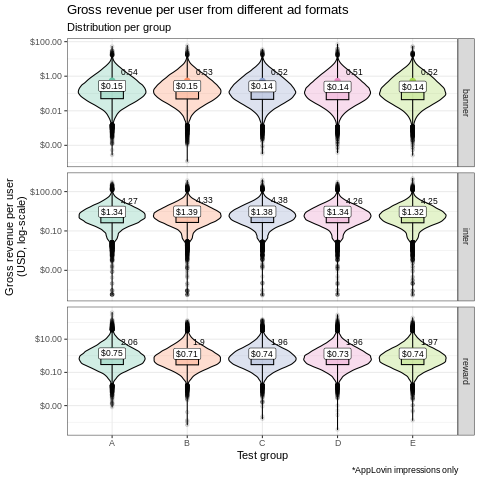

In [47]:
%%R -i df_revenue_per_format

options(warn = -1)

df_revenue_per_format_summary <-
  df_revenue_per_format |>
  group_by(group_id, ad_unit_format) |>
  summarise(median_revenue = median(revenue_amount, na.rm = TRUE),
            avg_revenue = round(mean(revenue_amount, na.rm = TRUE), 2),
            .groups = "drop")

df_revenue_per_format |>
  ggplot(aes(x = group_id, y = revenue_amount, fill = group_id)) +
    geom_violin(trim = TRUE, alpha = 0.3, color = "black") +
    geom_boxplot(color = "black", alpha = 0.3, outlier.alpha = 0.1, width = 0.3) +
    geom_point(data = df_revenue_per_format_summary,
               aes(x = group_id, y = avg_revenue, color = group_id),
               size = 2.5, inherit.aes = FALSE) +
    geom_label(data = df_revenue_per_format_summary,
               aes(x = group_id, y = median_revenue, label = dollar(median_revenue)),
               vjust = 0.1, size = 3, inherit.aes = FALSE) +
    geom_text(data = df_revenue_per_format_summary,
              aes(x = group_id, y = avg_revenue, label = avg_revenue),
              vjust = -1, hjust = -0.5, size = 3, inherit.aes = FALSE) +
    scale_x_discrete(name = "Test group", labels = function(x) sub(":.*", "", x)) +
    scale_y_log10(name = "Gross revenue per user\n(USD, log-scale)", labels = dollar) +
    scale_color_brewer(name = "", palette = "Set2") +
    scale_fill_brewer(name = "", palette = "Set2") +
    facet_grid(ad_unit_format~., scales = "free") +
    labs(caption = "*AppLovin impressions only") +
    ggtitle(label = "Gross revenue per user from different ad formats",
            subtitle = "Distribution per group") +
    theme_bw() +
    theme(legend.position = "none")

In [48]:
mwu_results = []

control_group = "A: default (control)"
test_groups = [
    g for g in df_revenue_per_format["group_id"].unique()
    if g != control_group
]

ad_formats = df_revenue_per_format["ad_unit_format"].unique()

# the test will be performed comparing each group vs control, one ad format at a time
for ad_format in ad_formats:

    # fetch control observations for this ad_format
    control_obs = df_revenue_per_format.loc[
        (df_revenue_per_format["group_id"] == control_group) &
        (df_revenue_per_format["ad_unit_format"] == ad_format),
        "revenue_amount"
    ].values

    control_users = len(control_obs)

    for tg in test_groups:

        # fetch test-group observations for this ad_format
        test_obs = df_revenue_per_format.loc[
            (df_revenue_per_format["group_id"] == tg) &
            (df_revenue_per_format["ad_unit_format"] == ad_format),
            "revenue_amount"
        ].values

        test_users = len(test_obs)

        # skip if one of them is empty (no users for that format/group)
        if control_users == 0 or test_users == 0:
            continue

        # perform the MWU test and extract U-statistic and raw p-value
        res = mannwhitneyu(
            control_obs,
            test_obs,
            alternative = "greater",
            method = "asymptotic"  # don't use "exact" for large samples (RIP runtime :3)
        )

        u_stat = res.statistic
        p_value = res.pvalue

        # calculate the common language effect size and Cliff's delta
        cles = u_stat / (control_users * test_users)
        cliffs_delta = (2 * cles) - 1

        # insert all data to results and append
        mwu_results.append({
            "ad_format": ad_format,
            "test_group": tg,
            "control_users": control_users,
            "test_users": test_users,
            "u_stat": u_stat,
            "p_value": p_value,
            "cles": cles,
            "cliffs_delta": cliffs_delta
        })

mwu_results = pd.DataFrame(mwu_results)

# initialize adjusted p-values as NaN (populate later)
mwu_results["p_adj"] = np.nan

# FDR correction per ad_format (4 tests per format)
for ad_format in ad_formats:
    mask = mwu_results["ad_format"] == ad_format
    if mask.sum() == 0:
        continue
    pvals = mwu_results.loc[mask, "p_value"]
    mwu_results.loc[mask, "p_adj"] = multipletests(pvals, method = "fdr_bh")[1]

mwu_results = (
  mwu_results
  .sort_values(["ad_format", "test_group"])
  .assign(stat_sign = lambda d: np.where(d['p_adj'] < 0.05, 'p < 0.05', 'not sign.'))
)

mwu_results


,ad_format,test_group,control_users,test_users,u_stat,p_value,cles,cliffs_delta,p_adj,stat_sign
1,banner,B: Nd_Order,108240,109423,5.981898e+09,2.171608e-05,0.505060,0.010119,2.171608e-05,p < 0.05
0,banner,C: Nd1_Order,108240,108151,5.984438e+09,8.020969e-20,0.511217,0.022433,1.069463e-19,p < 0.05
3,banner,D: Nd7_Order,108240,106300,5.959152e+09,3.631421e-47,0.517921,0.035842,1.452568e-46,p < 0.05
2,banner,E: Nd30_Order,108240,107093,5.991594e+09,2.993271e-42,0.516885,0.033769,5.986542e-42,p < 0.05
5,inter,B: Nd_Order,111142,113373,6.222053e+09,9.999998e-01,0.493794,-0.012412,9.999998e-01,not sign.
4,inter,C: Nd1_Order,111142,111198,6.111933e+09,9.999959e-01,0.494542,-0.010915,9.999998e-01,not sign.
7,inter,D: Nd7_Order,111142,109930,6.107447e+09,5.390996e-01,0.499879,-0.000241,9.999998e-01,not sign.
6,inter,E: Nd30_Order,111142,110190,6.137704e+09,1.700882e-01,0.501171,0.002341,6.803529e-01,not sign.
9,reward,B: Nd_Order,86042,84389,3.720405e+09,4.248185e-19,0.512382,0.024764,1.699274e-18,p < 0.05
8,reward,C: Nd1_Order,86042,86165,3.744990e+09,1.110967e-04,0.505137,0.010274,1.481289e-04,p < 0.05


Banner revenue increases are statistically significant across all test variants when compared to control. Impacts are moderate (Cliff's delta ranging from +0.01 to +0.03). Similar situations can be observed for rewarded video ads.

Interstitial ads show no significant uplifts.